Carga y configuración de la señal EMG del brazo en reposo

In [87]:
import numpy as np
from scipy.signal import freqz
from scipy.stats import kurtosis
import scipy.signal as signal
import matplotlib.pyplot as plt

# Cargar datos desde el archivo txt
file_path = "../../Documentacion/Laboratorios/Lab3_EMG/Brazo_oposicion.txt"  # Ruta del archivo
array = np.genfromtxt(file_path, skip_header=2)
canalA4 = array[:,8]

# Configuración de la señal
fs = 1000  # Frecuencia de muestreo en Hz
num_samples = canalA4.shape[0]  # Número de muestras
time = np.arange(len(canalA4)) / fs # Generar el vector de tiempo en segundos
VCC = 3.3  # Voltaje de operación
n = 10  # Número de bits del canal
EMG_V = (((canalA4 / pow(2, n)) - 0.5) * VCC) / num_samples
EMG_uV = EMG_V * pow(10, 6)

Comparación de filtros según la bibliografía
Filtrado 1: Butterworth pasabanda (5-500 Hz)  - Filtro Notch (60 Hz) - N°orden = 2
Filtrado 2: Butterworth pasabanda (20-500 Hz) - Filtro Notch (50 Hz) - N°orden = 2
Filtrado 3: Butterworth pasabanda (10-500 Hz) - Sin filtro Notch     - N°orden = 2
Filtrado 4: Butterworth pasabanda (20-350 Hz) - Filtro Notch (50 Hz) - N°orden = 2
Filtrado 5: Butterworth pasabanda (6-500 Hz)  - Sin filtro Notch     - N°orden = 2

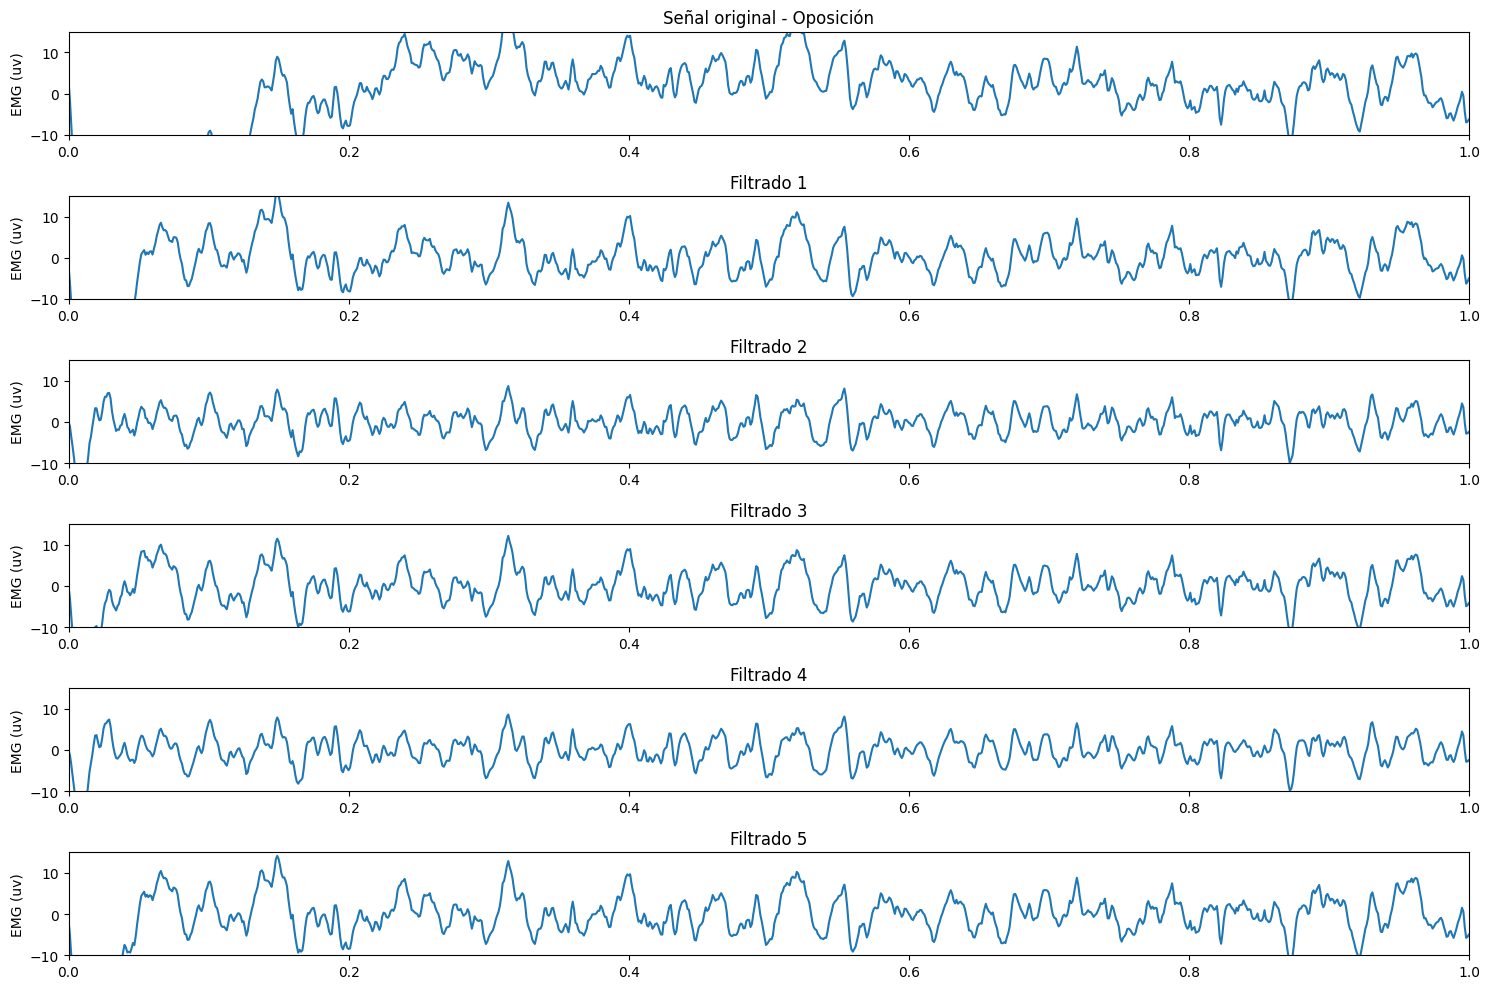

In [95]:
# Función para crear un filtro pasa banda Butterworth
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    if high >= 1.0:
        high = 0.99  # Ajuste para evitar error de frecuencia superior igual a la frecuencia de Nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Función para crear un filtro Notch
def notch_filter(freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = signal.iirnotch(freq, quality_factor)
    return b, a

# Función para filtrar una señal
def apply_filter(data, b, a):
    return signal.filtfilt(b, a, data)

# Aplicar los diferentes filtrados
filters = [
    {'name': 'Filtrado 1', 'lowcut': 5, 'highcut': 500, 'notch': 60},
    {'name': 'Filtrado 2', 'lowcut': 20, 'highcut': 500, 'notch': 50},
    {'name': 'Filtrado 3', 'lowcut': 10, 'highcut': 500, 'notch': None},
    {'name': 'Filtrado 4', 'lowcut': 20, 'highcut': 350, 'notch': 50},
    {'name': 'Filtrado 5', 'lowcut': 6, 'highcut': 500, 'notch': None}
]

filtered_signals = []

for f in filters:
    # Aplicar filtro pasa banda
    b_band, a_band = butter_bandpass(f['lowcut'], f['highcut'], fs)
    filtered_signal = apply_filter(EMG_uV, b_band, a_band)
    
    # Aplicar filtro Notch si es necesario
    if f['notch']:
        b_notch, a_notch = notch_filter(f['notch'], fs)
        filtered_signal = apply_filter(filtered_signal, b_notch, a_notch)
    
    filtered_signals.append({'name': f['name'], 'signal': filtered_signal})

# Plotear las señales filtradas
plt.figure(figsize=(15, 10))
plt.subplot(6, 1, 1)
plt.plot(time, EMG_uV)
plt.ylim(-10, 15)
plt.ylabel('EMG (uv)')
plt.xlim(0, 1)
plt.title('Señal original - Oposición')

for i, f in enumerate(filtered_signals, start=2):
    plt.subplot(6, 1, i)
    plt.plot(time, f['signal'])
    plt.ylim(-10, 15)
    plt.ylabel('EMG (uv)')
    plt.xlim(0, 1)
    plt.title(f['name'])

plt.tight_layout()
plt.show()

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_32340\3289948206.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fs * 0.5 * w_band / np.pi, 20 * np.log10(np.abs(h_band)))


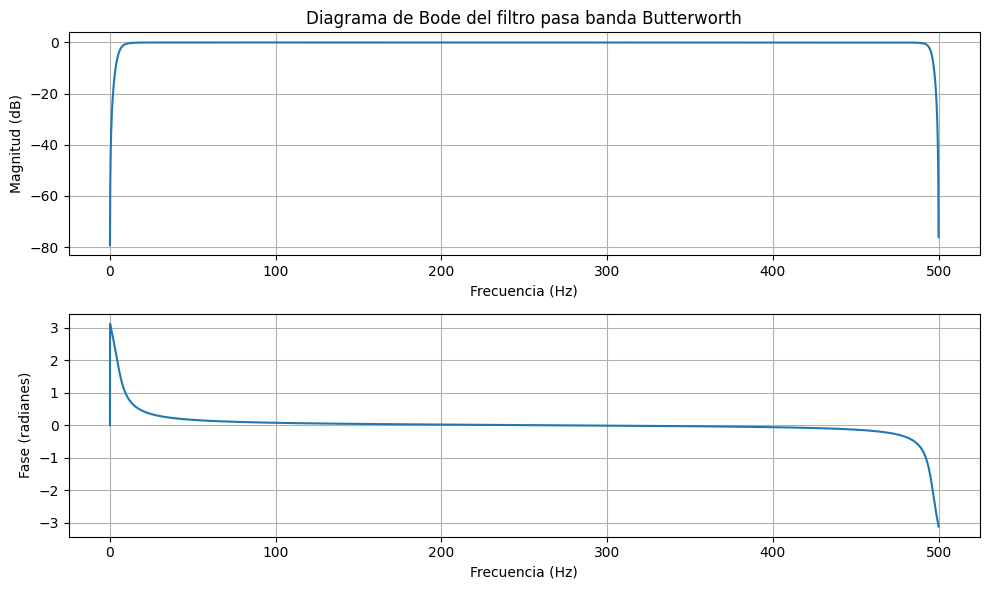

In [89]:
# Calcular la respuesta en frecuencia del filtro pasa banda Butterworth
w_band, h_band = freqz(b_band, a_band, worN=8000)

# Plotear el diagrama de Bode del filtro pasa banda Butterworth
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(fs * 0.5 * w_band / np.pi, 20 * np.log10(np.abs(h_band)))
plt.title('Diagrama de Bode del filtro pasa banda Butterworth')
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(fs * 0.5 * w_band / np.pi, np.angle(h_band))
plt.ylabel('Fase (radianes)')
plt.xlabel('Frecuencia (Hz)')
plt.grid()

plt.tight_layout()
plt.show()


In [90]:
# Ventana a usar
window_size = int(0.150 * fs)  # 150 ms en muestras
window = np.hanning(window_size)

# Segmentación de la señal filtrada con una ventana de Hanning de 150 ms
segmented_signals = []
increment = int(0.050 * fs)  # Incremento de 50 ms en muestras

for i in range(0, len(filtered_signals[3]['signal']) - window_size, increment):
    segment = filtered_signals[3]['signal'][i:i+window_size] * window
    segmented_signals.append(segment)

# Mostrar el número de segmentos obtenidos
print("Número de segmentos:", len(segmented_signals))


Número de segmentos: 579


Tiempos de inicio de activación:
[ 1.08   3.394  3.468  4.346  7.904  8.215  9.593  9.884 10.664 12.192
 12.548 12.81  13.488 14.597 15.123 15.905 16.932 17.113 18.27  18.637
 18.696 19.168 20.493 23.346 24.682 25.549 25.668 26.099 26.294 27.106
 28.17 ]
Tiempos de fin de activación:
[ 1.515  3.431  3.541  4.55   7.963  8.651  9.831  9.938 11.026 12.513
 12.732 12.993 13.508 15.061 15.329 16.259 17.012 17.22  18.62  18.684
 18.723 19.514 20.89  23.777 25.093 25.65  26.09  26.281 26.455 27.525
 28.85 ]


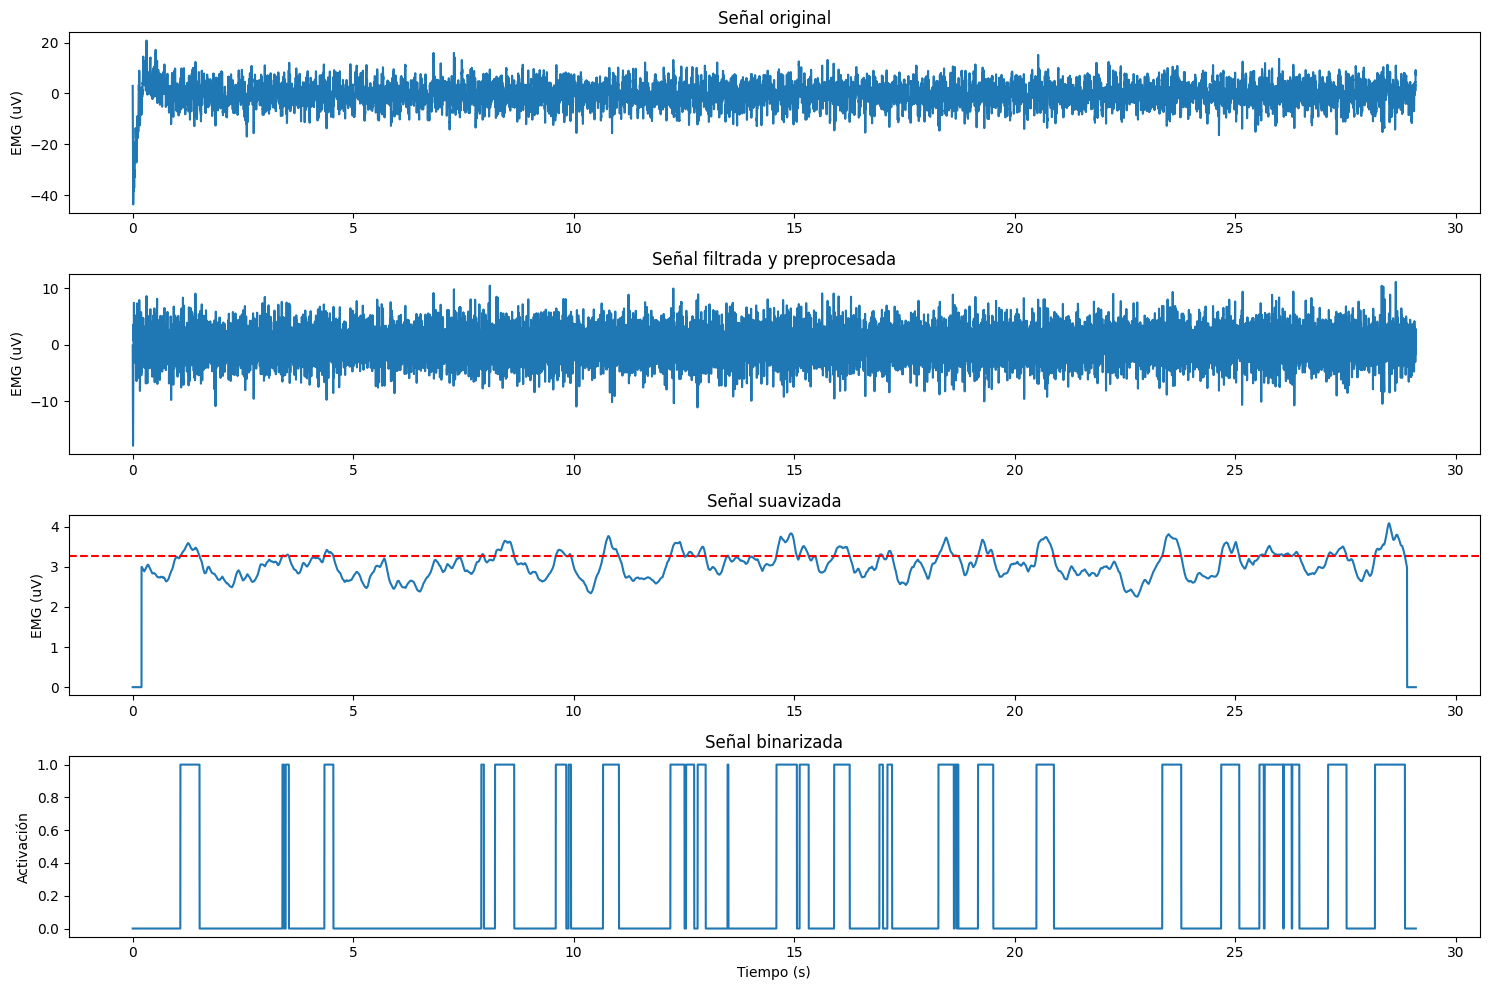

In [91]:
# Seleccionar la señal filtrada a utilizar
pre_pro_signal = filtered_signals[3]['signal'] - np.average(filtered_signals[3]['signal'])

# Aplicación del operador TKEO
tkeo = []
for i in range(0, len(pre_pro_signal)):
    if i == 0 or i == len(pre_pro_signal) - 1:
        tkeo.append(pre_pro_signal[i])
    else:
        tkeo.append(np.power(pre_pro_signal[i], 2) - (pre_pro_signal[i + 1] * pre_pro_signal[i - 1]))

# Suavizado de la señal
smoothing_level_perc = 20  # Porcentaje
smoothing_level = int((smoothing_level_perc / 100) * fs)

# Rectificación de la señal
rect_signal = np.absolute(tkeo)

# Primera etapa de suavizado: Media móvil
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

rect_signal = moving_average(rect_signal, fs // 10)

# Segunda etapa de suavizado
smooth_signal = []
for i in range(0, len(rect_signal)):
    if smoothing_level < i < len(rect_signal) - smoothing_level:
        smooth_signal.append(np.mean(rect_signal[i - smoothing_level:i + smoothing_level]))
    else:
        smooth_signal.append(0)

# Definición del umbral
avg_pre_pro_signal = np.average(pre_pro_signal)
std_pre_pro_signal = np.std(pre_pro_signal)

def normReg(thresholdLevel):
    threshold_0_perc_level = (- avg_pre_pro_signal) / float(std_pre_pro_signal)
    threshold_100_perc_level = (np.max(smooth_signal) - avg_pre_pro_signal) / float(std_pre_pro_signal)
    m, b = np.polyfit([0, 100], [threshold_0_perc_level, threshold_100_perc_level], 1)
    return m * thresholdLevel + b 

threshold_level = 80  # % Relativo al valor promedio de la señal suavizada
threshold_level_norm_10 = normReg(threshold_level)

threshold_10 = avg_pre_pro_signal + threshold_level_norm_10 * std_pre_pro_signal

# Binarización de la señal suavizada
binary_signal = []
for i in range(0, len(time)):
    if smooth_signal[i] >= threshold_10:
        binary_signal.append(1)
    else:
        binary_signal.append(0)

# Detección de periodos de activación
diff_signal = np.diff(binary_signal)
act_begin = np.where(diff_signal == 1)[0]
act_end = np.where(diff_signal == -1)[0]

# Mostrar los resultados
print("Tiempos de inicio de activación:")
print(time[act_begin])
print("Tiempos de fin de activación:")
print(time[act_end])

# Plotear la señal original, filtrada, suavizada y binarizada
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(time, EMG_uV)
plt.ylabel('EMG (uV)')
plt.title('Señal original')

plt.subplot(4, 1, 2)
plt.plot(time, pre_pro_signal)
plt.ylabel('EMG (uV)')
plt.title('Señal filtrada y preprocesada')

plt.subplot(4, 1, 3)
plt.plot(time, smooth_signal)
plt.axhline(y=threshold_10, color='r', linestyle='--')
plt.ylabel('EMG (uV)')
plt.title('Señal suavizada')

plt.subplot(4, 1, 4)
plt.plot(time[:-1], binary_signal[:-1])
plt.ylabel('Activación')
plt.xlabel('Tiempo (s)')
plt.title('Señal binarizada')

plt.tight_layout()
plt.show()

In [92]:
# Calcular características en el dominio del tiempo
def wilson_amplitude(signal, threshold):
    return np.sum(np.abs(np.diff(signal)) > threshold)

def rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iemg(signal):
    return np.sum(np.abs(signal))

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def zero_crossings(signal):
    return np.sum(np.diff(np.sign(signal)) != 0)

def ssc(signal):
    diff_signal = np.diff(signal)
    return np.sum(np.diff(np.sign(diff_signal)) != 0)

# Calcular características en el dominio del tiempo
threshold_wamp = 0.02  # Definir el umbral para WAMP
wamp = wilson_amplitude(pre_pro_signal, threshold_wamp)
rms_value = rms(pre_pro_signal)
mav_value = mav(pre_pro_signal)
iemg_value = iemg(pre_pro_signal)
wl_value = waveform_length(pre_pro_signal)
zc_value = zero_crossings(pre_pro_signal)
ssc_value = ssc(pre_pro_signal)

print("Amplitud de Wilson (WAMP):", wamp)
print("Raíz cuadrada media (RMS):", rms_value)
print("Valor absoluto medio (MAV):", mav_value)
print("EMG integrado (iEMG):", iemg_value)
print("Longitud de la forma de onda (WL):", wl_value)
print("Cruces por cero (ZC):", zc_value)
print("Cambios en el signo de la pendiente (SSC):", ssc_value)

Amplitud de Wilson (WAMP): 28737
Raíz cuadrada media (RMS): 2.8637919204933153
Valor absoluto medio (MAV): 2.2813956070227857
EMG integrado (iEMG): 66388.61216436306
Longitud de la forma de onda (WL): 29494.641816939744
Cruces por cero (ZC): 4126
Cambios en el signo de la pendiente (SSC): 8072


Potencia absoluta (CWT_power): 60821673.07560757
Curtosis (CWT_kurtosis): 6.4897662751943415
Entropía wavelet (WE): 32613.426956435862


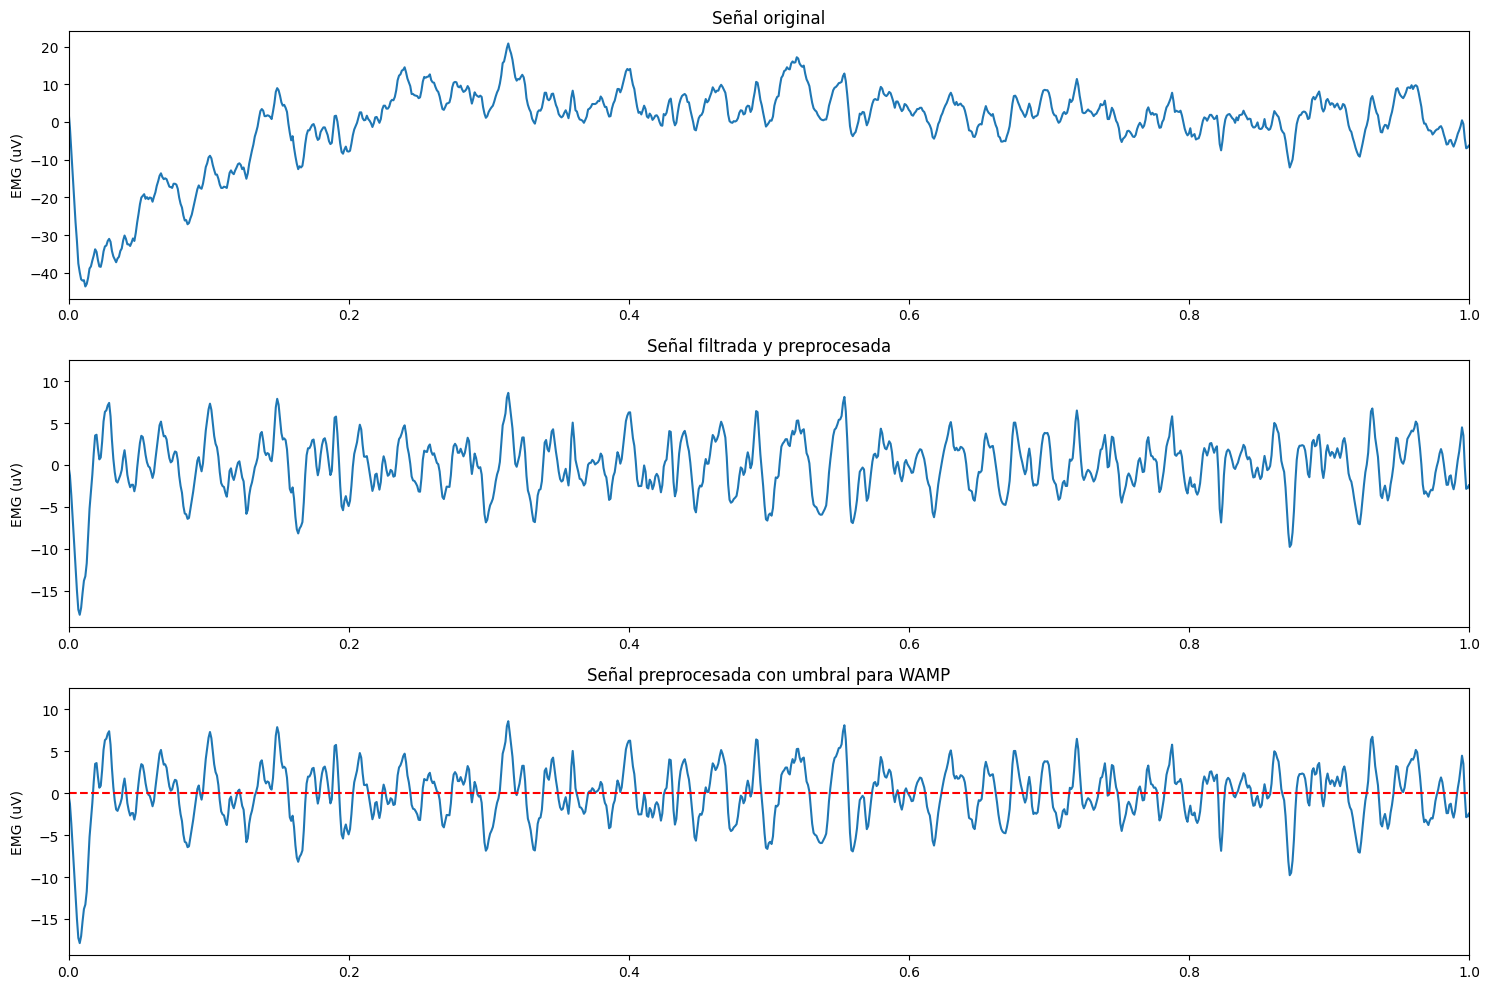

In [93]:
# Funciones para calcular características en el dominio tiempo-frecuencia usando la Transformada Wavelet Continua (CWT)
def cwt_features(signal, wavelet='morl'):
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 128), wavelet=wavelet)
    cwt_power = np.sum(np.square(coeffs))
    cwt_kurtosis = kurtosis(coeffs.flatten())
    cwt_entropy = -np.sum(coeffs * np.log(np.abs(coeffs) + 1e-10))  # Evitar log(0)
    return cwt_power, cwt_kurtosis, cwt_entropy

cwt_power, cwt_kurtosis, cwt_entropy = cwt_features(pre_pro_signal)

print("Potencia absoluta (CWT_power):", cwt_power)
print("Curtosis (CWT_kurtosis):", cwt_kurtosis)
print("Entropía wavelet (WE):", cwt_entropy)

# Plotear la señal original, filtrada y las características calculadas
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(time, EMG_uV)
plt.ylabel('EMG (uV)')
plt.xlim(0, 1)
plt.title('Señal original')

plt.subplot(3, 1, 2)
plt.plot(time, pre_pro_signal)
plt.ylabel('EMG (uV)')
plt.xlim(0, 1)
plt.title('Señal filtrada y preprocesada')

plt.subplot(3, 1, 3)
plt.plot(time, pre_pro_signal)
plt.axhline(y=threshold_wamp, color='r', linestyle='--')
plt.ylabel('EMG (uV)')
plt.xlim(0, 1)
plt.title('Señal preprocesada con umbral para WAMP')

plt.tight_layout()
plt.show()